In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [2]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power_two_sample import power, power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
simulations = {'joint_normal': (joint_sim, 4), 'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 'step': (step_sim, 5), 
               'spiral': (spiral_sim, 8), 'circle': (circle_sim, 16), 'ellipse': (circle_sim, 17), 'diamond': (square_sim, 18),
               'log': (log_sim, 10)}

In [4]:
def power_vs_angle_parallel(params_dict):
    angles = [i for i in range(0, 200, 20)]
    estimated_power = np.zeros(len(angles))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(angles)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=1, theta=angles[i])
    
    np.savetxt('{}_{}_angle_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [5]:
def make_sim_list(params_dict):
    sim = params_dict['simulation_type']
    return sim

In [6]:
def fill_params_dict_list_angles():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [7]:
%%time
params_dict = fill_params_dict_list_angles()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_angle_parallel, params_dict)

<class 'list'>
4 cca
4 unbiased
12 rv
12 rv finished
12 cca
4 cca finished
12 unbiased
12 cca finished
13 unbiased
4 unbiased finished
4 biased
12 unbiased finished
12 biased
13 unbiased finished
13 biased
4 biased finished
4 mantel
12 biased finished
12 mantel
13 biased finished
13 mantel
4 mantel finished
4 mgc
12 mantel finished
12 mgc
13 mantel finished
13 mgc
4 mgc finished
4 pearson
4 pearson finished
4 rv
4 rv finished
13 pearson
12 mgc finished
12 pearson
13 pearson finished
13 rv
12 pearson finished
5 mgc
13 rv finished
13 cca
13 mgc finished
8 mantel
13 cca finished
5 unbiased
8 mantel finished
8 mgc
5 unbiased finished
5 biased
5 biased finished
5 mantel
5 mantel finished
16 biased
16 biased finished
16 mantel
16 mantel finished
16 mgc
5 mgc finished
5 pearson
5 pearson finished
5 rv
5 rv finished
5 cca
5 cca finished
8 unbiased
8 mgc finished
8 pearson
8 pearson finished
8 rv
8 rv finished
8 cca
8 cca finished
16 unbiased
8 unbiased finished
8 biased
16 unbiased finished
17

In [21]:
def plot_all_curves():
    simulation_names = ['joint_normal', 'sine_4pi', 'sine_16pi', 'step', 'spiral', 'circle', 
                        'ellipse', 'diamond','log']
    simulation_num = [4, 12, 13, 5, 8, 16, 17, 18, 10]
        
        
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            sim_num  = simulation_num[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(sim_num), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_angle_matlab_new.csv'.format(sim_num, test), delimiter=',')
                x_axis = [i for i in range(0,200,20)]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Angle')
    plt.savefig('power_curves_angles_new')

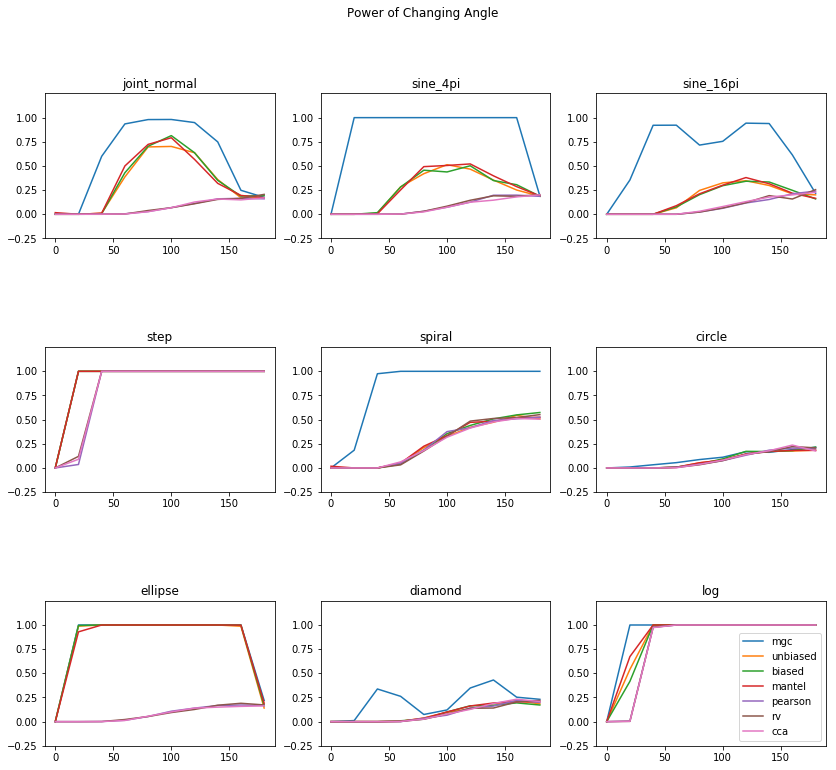

In [22]:
plot_all_curves()

In [19]:
def plot_diff():
    simulation_names = ['joint_normal', 'sine_4pi', 'sine_16pi', 'step', 'spiral', 'circle', 
                        'ellipse', 'diamond','log']
    simulation_num = [4, 12, 13, 5, 8, 16, 17, 18, 10]
        
        
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            sim_num  = simulation_num[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']

            for test in tests:
                power = np.genfromtxt('{}_{}_angle_matlab.csv'.format(sim_num, test), delimiter=',')
                new_power = np.genfromtxt('{}_{}_angle_matlab_new.csv'.format(sim_num, test), delimiter=',')
                diff = new_power - power
                x_axis = [i for i in range(0,200,20)]
                col.plot(x_axis, diff, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Angle for New Transform Function vs Old Transform Function')
    plt.savefig('power_curves_angles_diff')

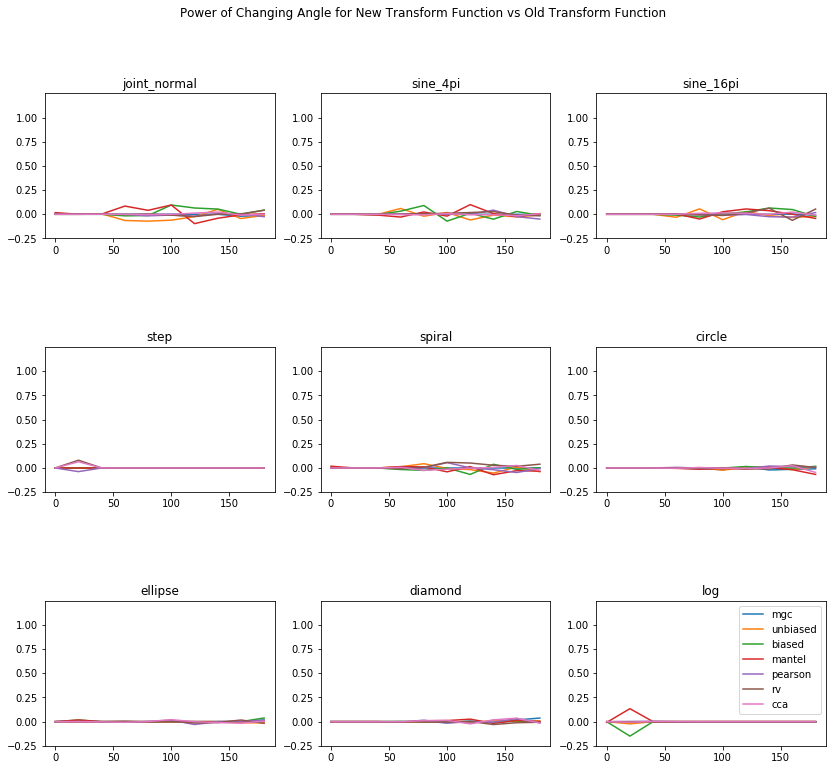

In [20]:
plot_diff()